In [32]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
from scipy.special import erf
import os
import json
import pandas as pd
from tqdm import tqdm
from typing import Union
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking, GlobalMaxPooling1D, Input, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

initial_lr = 0.001  # Starting learning rate, adjust as needed

plt.rcParams['figure.facecolor'] = 'white'

def EFP(time: np.int32 | npt.NDArray[np.int32], amplitude: np.float64, mu: np.float64, sigma: np.float64, tau: np.float64, a: np.float64, background: np.float64) -> np.float64 | npt.NDArray[np.float64]:
    Aprime = amplitude * sigma / (tau * np.sqrt(2 / np.pi))
    y1 = -(time - mu) / tau + sigma**2 / (2 * tau**2)
    y2 = (time - mu) / (np.sqrt(2) * sigma) - sigma / (np.sqrt(2) * tau)
    return Aprime * np.exp(y1) * (1 + erf(y2)) + a * time + background

def plot_flare(identifier: str, pred=None, act=None, save_dir=None):
    dirname = ''
    datafile = f'{dirname}flares/{identifier}.csv'
    df = pd.read_csv(datafile)
    summaryfile = f'{dirname}allflares_processed_5.csv'
    allcsv = pd.read_csv(summaryfile)
    row = allcsv[allcsv['identifier'] == identifier].iloc[0]

    fig, axs = plt.subplots(2, figsize=(9.6, 9.6), gridspec_kw={'height_ratios': [3, 1]})

    if act != None and pred != None:
        axs[0].set_title(f"{identifier}: pred: {pred}, actual: {act}")
    else:
        axs[0].set_title(f'{identifier}')
    plt.xlabel('Time (s)')
    plt.subplots_adjust(hspace=.0)
    linestyle = {"elinewidth":1, "capsize":0, "ecolor":"grey"}
    plt.setp(axs[0].get_xticklabels(), visible=False)

    xt = df['Time']
    yt = df['Counts']
    yerr = df['Error']

    axs[0].errorbar(xt, yt, yerr=yerr, fmt='D', ms=3, c='blue', **linestyle)

    for ax in axs:
        ax.tick_params(which='major', width=1)
        ax.tick_params(which='major', length=4)
        ax.margins(x=0)
    axs[0].set_ylabel('Flux (nW/m$^2$)')
    axs[1].set_ylabel('Residual ((o-f)/$\\sigma$)')
    axs[1].set_ylim(bottom=-4,top=4)

    range = (np.max(yt) - np.min(yt))/10
    axs[0].scatter(row['start_time'], \
        row['start_count'], c='k', s=30, zorder=15)
    axs[0].vlines(x=row['start_time'], \
        ymin=row['start_count'] - range, \
        ymax=row['end_count'] + range, color='k', linestyle='dotted', linewidth=2)
    axs[0].scatter(row['end_time'], \
        row['end_count'], c='k', s=30, zorder=15)
    axs[0].vlines(x=row['end_time'], \
        ymin=row['end_count'] - range, \
        ymax=row['end_count'] + range, color='k', linestyle='dotted', linewidth=2)

    yfit = EFP(xt, row['amplitude'], row['mu'], row['sigma'], row['tau'], row['slope'], row['background'])
    axs[0].plot(xt, yfit, c='r', zorder=10, lw=3)
    axs[0].tick_params(axis='x', direction='in')
    axs[1].errorbar(xt, (yt-yfit)/np.std(yt-yfit), yerr=yerr/np.std(yt-yfit), fmt='D', ms=3, c='blue', **linestyle)
    axs[1].axhline(np.mean((yt-yfit)/np.std(yt-yfit)), linestyle='--', lw=1, c='navy')

    if save_dir != None:
        plt.savefig(save_dir)

    plt.show()

def generate_new_model(data_shape, verbose=0):
    # Initialize the sequential model
    model1 = Sequential()
    
    # Input layer
    model1.add(Input(shape=data_shape))
    
    # Masking layer to ignore zero values
    model1.add(Masking(mask_value=0.0))
    
    # First set of convolutions
    model1.add(Conv1D(filters=64, kernel_size=50, activation='relu', padding='same'))
    model1.add(Conv1D(filters=64, kernel_size=20, activation='relu', padding='same'))
    model1.add(Conv1D(filters=64, kernel_size=10, activation='relu', padding='same'))
    
    # Max pooling layer
    model1.add(MaxPooling1D(pool_size=2))
    
    # Second set of convolutions (dilated)
    model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', dilation_rate=4))
    model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', dilation_rate=16))
    model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', dilation_rate=64))
    
    # Max pooling layer
    model1.add(MaxPooling1D(pool_size=2))
    
    # Flatten the output
    model1.add(Flatten())
    
    # Fully connected layer
    model1.add(Dense(128, activation='relu'))
    model1.add(Dropout(0.5))
    
    # Output layer
    model1.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=initial_lr)
    
    # Compile the model
    model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    if verbose:
        model1.summary()

    return model1

def generate_new_deriv_model(data_shape, verbose=0):
    model2 = Sequential()

    model2.add(Input(shape=data_shape))
    
    model2.add(Masking(mask_value=0.0))
        
    # First convolutional layer
    model2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model2.add(MaxPooling1D(pool_size=2))
    model2.add(Dropout(0.5))
    
    # Second convolutional layer
    model2.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model2.add(MaxPooling1D(pool_size=2))
    model2.add(Dropout(0.5))
    
    # Third convolutional layer
    model2.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model2.add(MaxPooling1D(pool_size=2))
    model2.add(Dropout(0.5))
    
    model2.add(Flatten())
    
    # Fully connected layer
    model2.add(Dense(128, activation='relu'))
    model2.add(Dropout(0.5))
    
    # Output layer
    model2.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=initial_lr)
    
    # Compile the model
    model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    if verbose:
        model2.summary()

    return model2

def plot_roc(valid, test):
    fpr, tpr, thresh = roc_curve(valid, test)
    auc_val = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_val)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    #plt.xscale('log')
    #plt.yscale('log')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.show()

    return fpr, tpr

In [44]:
class_info = pd.read_csv('sim6/fitted_flares.csv')

data = []
data_deriv = []
labels = []
ids = []
count_err_syn = {'A': [], 'B': []}
count_snr_syn = {'A': [], 'B': []}

tot_flares = 0
maxlen = 2089

for i, iden in enumerate(tqdm(np.array(class_info['identifier']))):    
    try:
        tod = pd.read_csv('sim6/binned_flares/' + str(iden) + '.csv')
    except FileNotFoundError:
        continue

    if len(tod['Counts']) > maxlen:
        maxlen = len(tod['Counts'])

    # amplitude: np.float64, mu: np.float64, sigma: np.float64, tau: np.float64, a: np.float64, background
    yfit = EFP(tod['Time'], class_info['amplitude'][i], class_info['mu'][i], class_info['sigma'][i], class_info['tau'][i], class_info['background_slope'][i], class_info['background_intercept'][i])

    count_err_syn[class_info['flare_type'][i]].append(np.std(tod['Counts']-yfit))
    count_snr_syn[class_info['flare_type'][i]].append(class_info['amplitude'][i]/np.std(tod['Counts']-yfit))

    tot_flares += 1
    data.append(list(tod['Counts']/np.max(tod['Counts'])))
    data_deriv.append(list(np.diff(tod['Counts'])))
    
    if class_info['flare_type'][i] == 'A':
        labels.append(0)
    else:
        labels.append(1)

    ids.append(class_info['identifier'][i])

data = pad_sequences(data, padding='post', dtype=float, maxlen=maxlen)   # the padding is to adjust the shape of the np arrays
data_deriv = pad_sequences(data_deriv, padding='post', dtype=float, maxlen=maxlen)   # the padding is to adjust the shape of the np arrays

print(len(data))
print(len(data_deriv))

with open('count_err_syn.json', 'w') as f:
    json.dump(count_err_syn, f)

with open('count_snr_syn.json', 'w') as f:
    json.dump(count_snr_syn, f)

100%|██████████████████████████████████████| 8716/8716 [00:13<00:00, 664.30it/s]


8716
8716


In [45]:
real_info = pd.read_csv('allflares_processed_5.csv')
filenames = [f.split('.png')[0] for f in os.listdir('plots_strict')]

real_data = []
real_data_deriv = []
real_labels = []
real_ids = []
count_err_real = {'A': [], 'B': []}
count_snr_real = {'A': [], 'B': []}

for i, iden in enumerate(tqdm(np.array(real_info['identifier']))):
    try:
        tod = pd.read_csv('flares/' + str(iden) + '.csv')
    except FileNotFoundError:
        continue

    if iden not in filenames:
        continue

    yfit = EFP(tod['Time'],real_info['amplitude'][i],real_info['mu'][i],real_info['sigma'][i],real_info['tau'][i], real_info['slope'][i],real_info['background'][i])
    
    count_err_real[real_info['flare_type'][i]].append(np.std(tod['Counts']-yfit))
    count_snr_real[real_info['flare_type'][i]].append(np.std(tod['Counts']-yfit))

    real_data.append(list(tod['Counts']/np.max(tod['Counts'])))
    real_data_deriv.append(list(np.diff(tod['Counts'])))
    
    if real_info['flare_type'][i] == 'A':
        real_labels.append(0)
    else:
        real_labels.append(1)

    real_ids.append(real_info['identifier'][i])

real_labels = np.array(real_labels)

real_data = pad_sequences(real_data, padding='post', dtype=float, maxlen=maxlen)   # the padding is to adjust the shape of the np arrays
real_data_deriv = pad_sequences(real_data_deriv, padding='post', dtype=float, maxlen=maxlen)   # the padding is to adjust the shape of the np arrays

print(len(real_data))
print(len(real_data_deriv))

with open('count_err_real.json', 'w') as f:
    json.dump(count_err_real, f)

with open('count_snr_real.json', 'w') as f:
    json.dump(count_snr_real, f)

100%|████████████████████████████████████████| 404/404 [00:00<00:00, 795.99it/s]

268
268


1/8 iterations


/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_162' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 351838.65it/s]


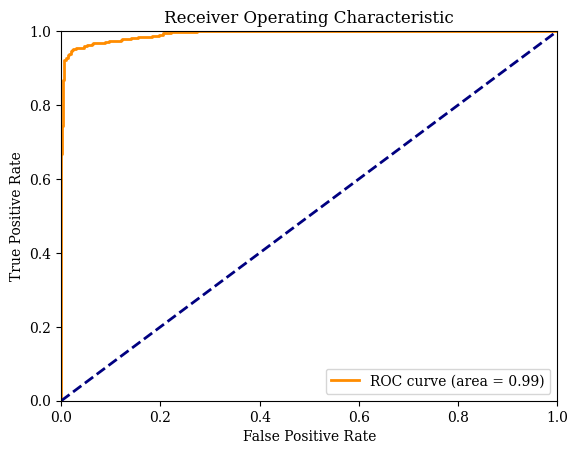

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 197900.26it/s]


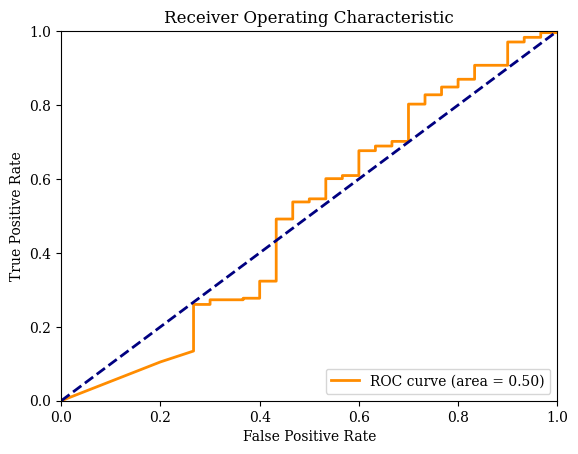

/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_168' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 354127.91it/s]
/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_162' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 352598.44it/s]


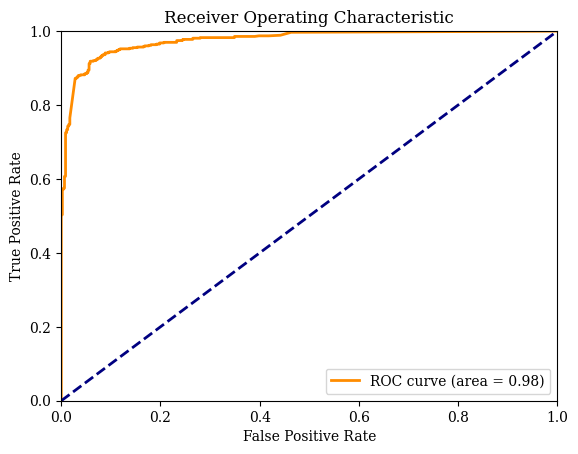

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 340834.89it/s]


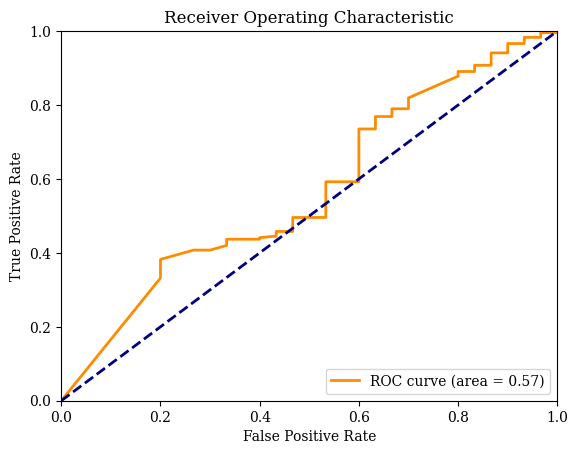

2/8 iterations


/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_171' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 347823.44it/s]


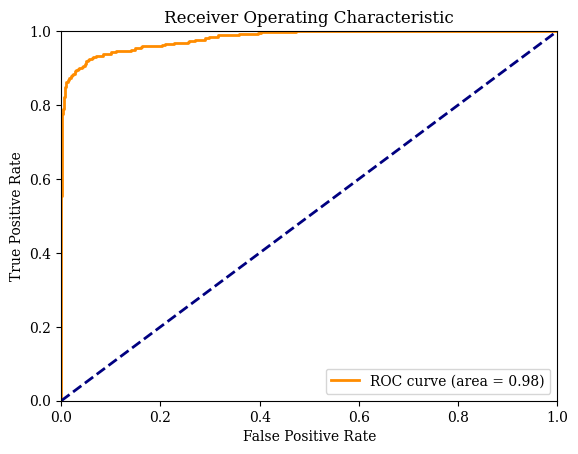

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 349308.10it/s]


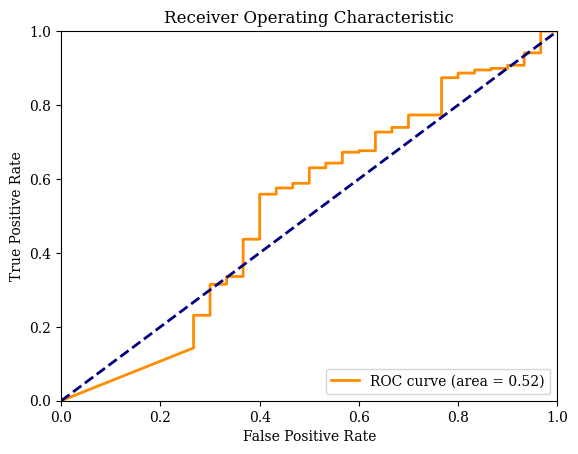

/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_177' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 341586.32it/s]
/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_171' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 373878.91it/s]


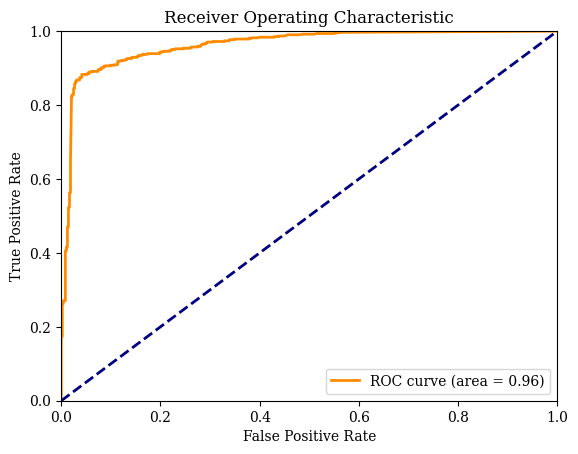

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 354709.21it/s]


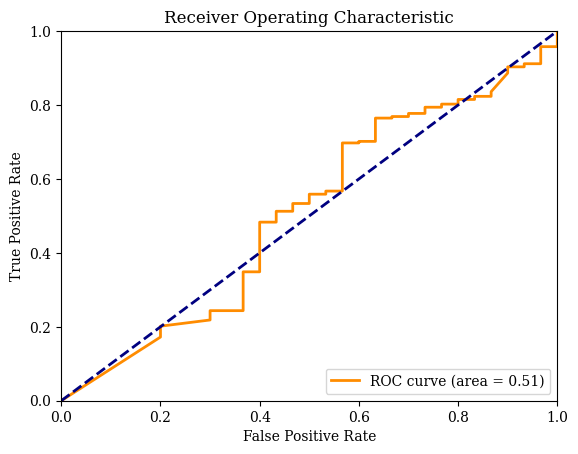

3/8 iterations


/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_180' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 355560.07it/s]


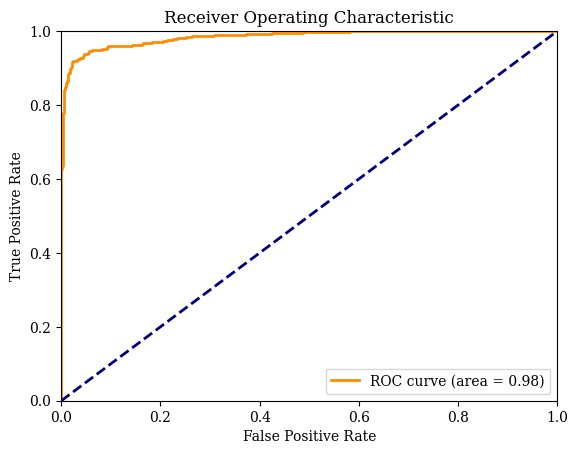

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 328100.84it/s]


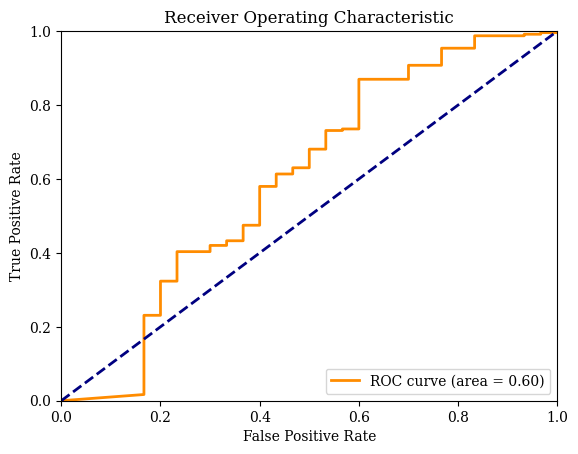

/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_186' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 351784.50it/s]
/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_180' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 347796.98it/s]


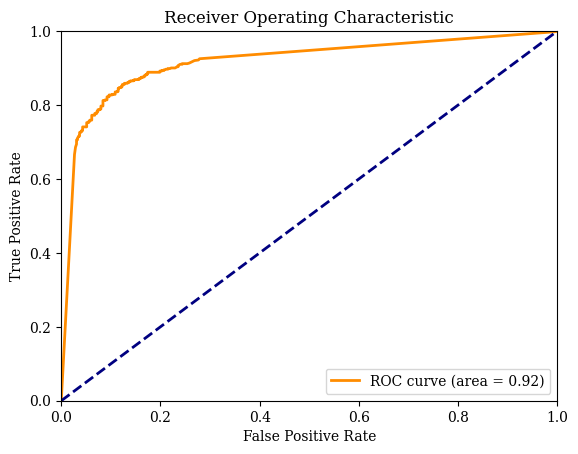

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 346294.97it/s]


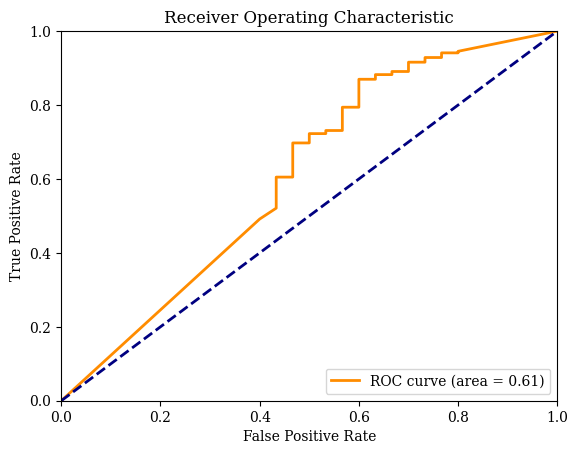

4/8 iterations


/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_189' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 376031.53it/s]


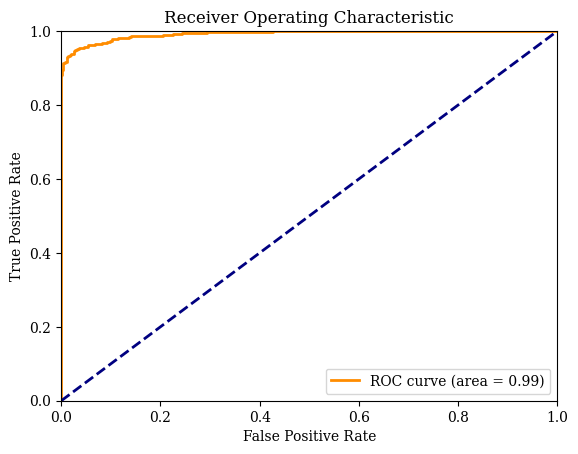

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 327241.19it/s]


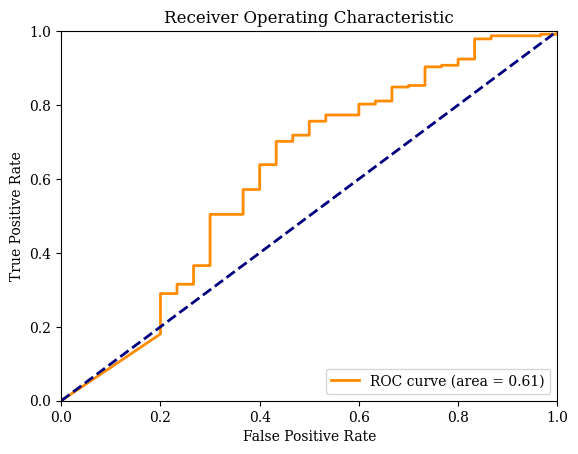

/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_195' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 367241.65it/s]
/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_189' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


100%|███████████████████████████████████| 1090/1090 [00:00<00:00, 366740.84it/s]


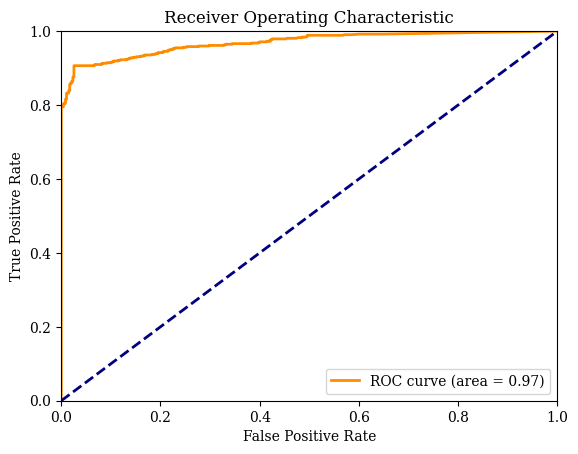

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 348874.45it/s]


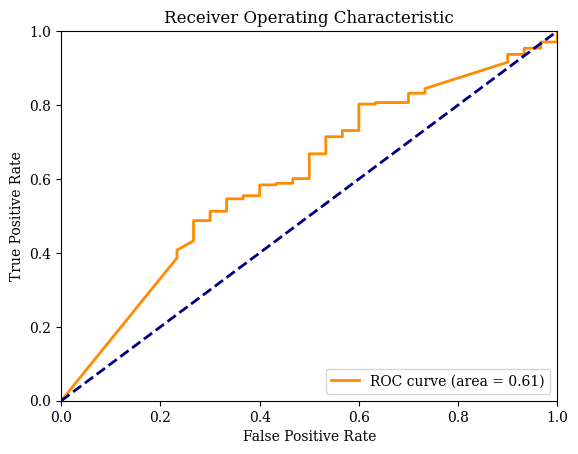

5/8 iterations


/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_198' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 357038.78it/s]


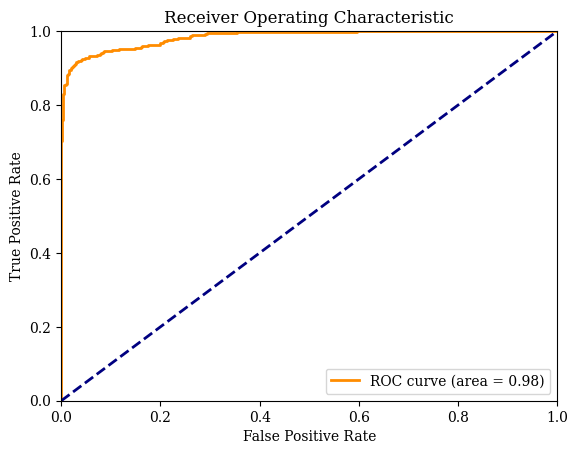

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 330999.26it/s]


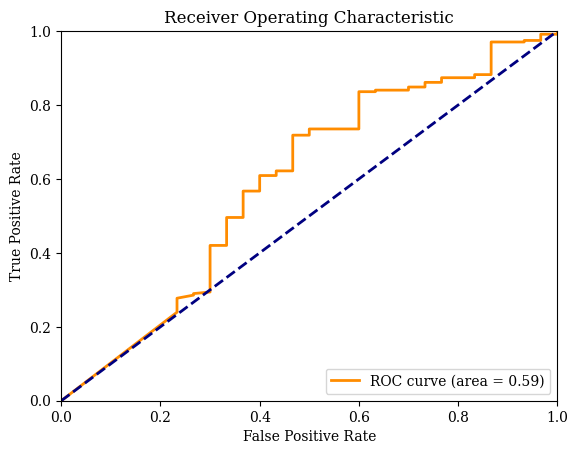

/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_204' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 368324.90it/s]
/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_198' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 342578.34it/s]


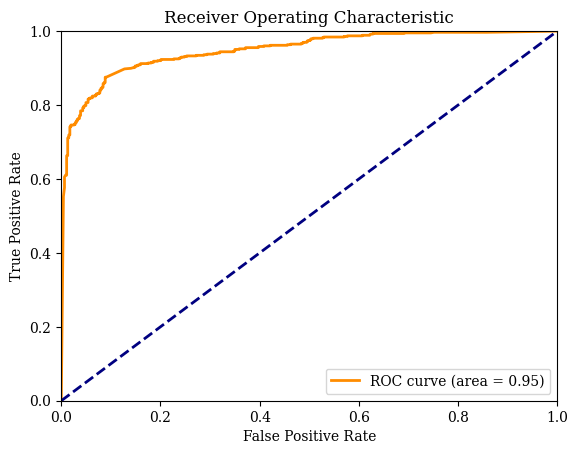

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 328388.39it/s]


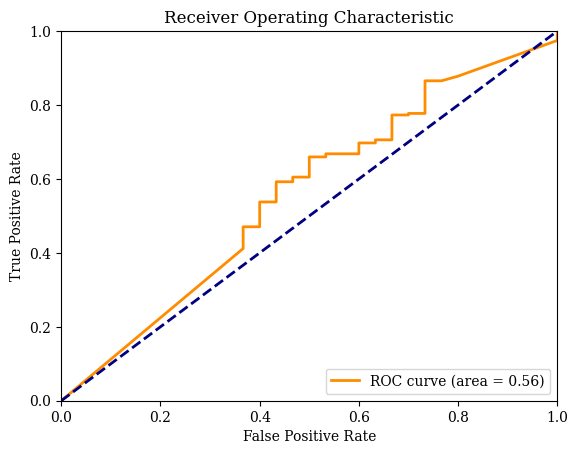

6/8 iterations


/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_207' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 356370.22it/s]


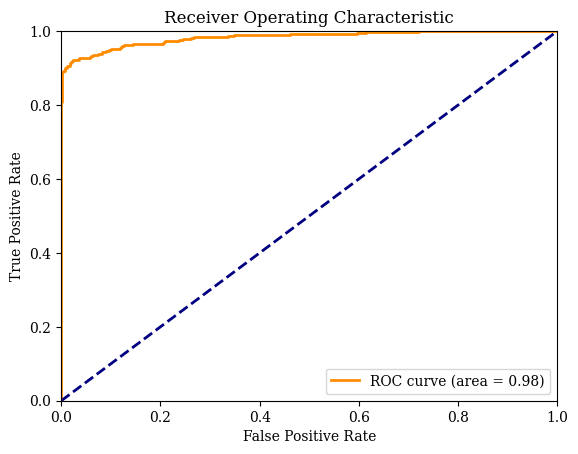

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 344702.08it/s]


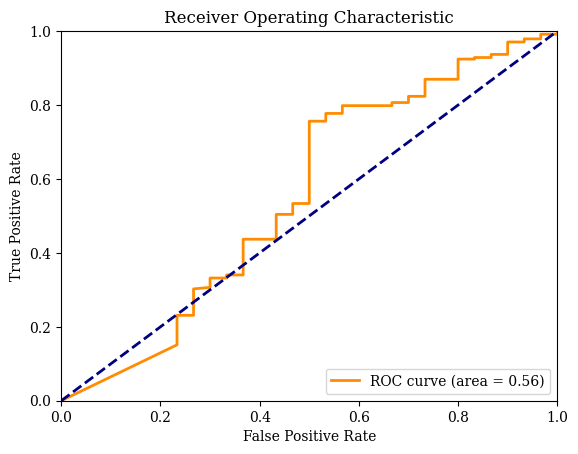

/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_213' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 358833.93it/s]
/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_207' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 324218.98it/s]


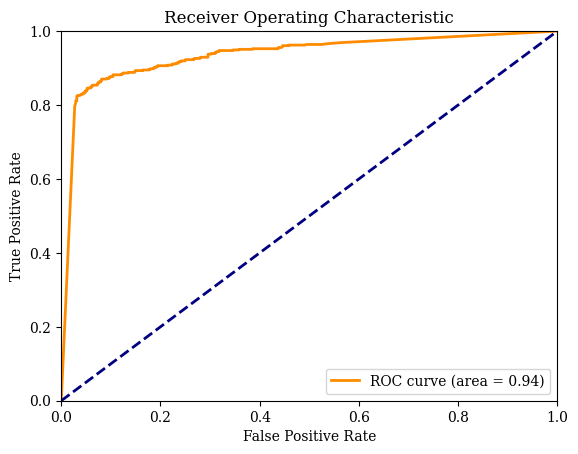

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 342392.16it/s]


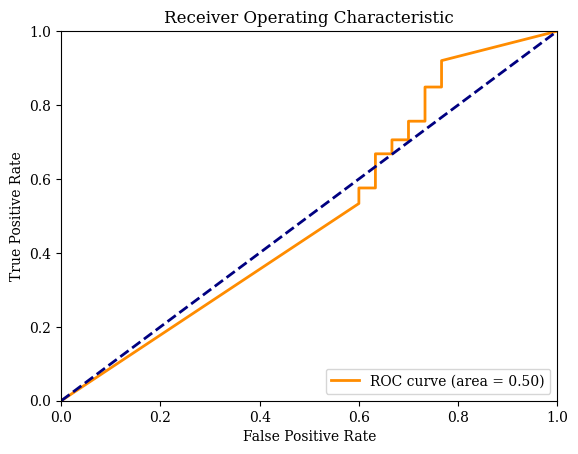

/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_216' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


7/8 iterations
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 361703.92it/s]


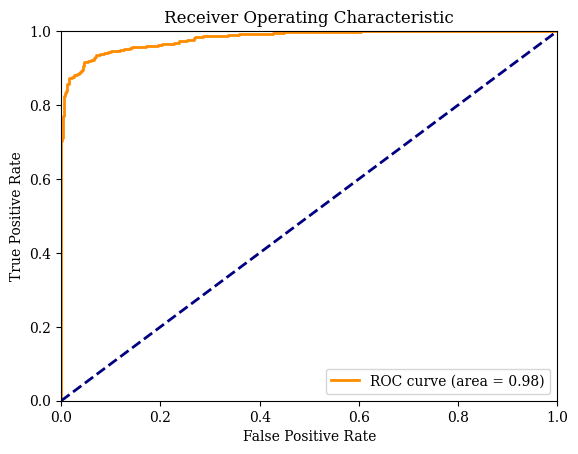

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 337154.61it/s]


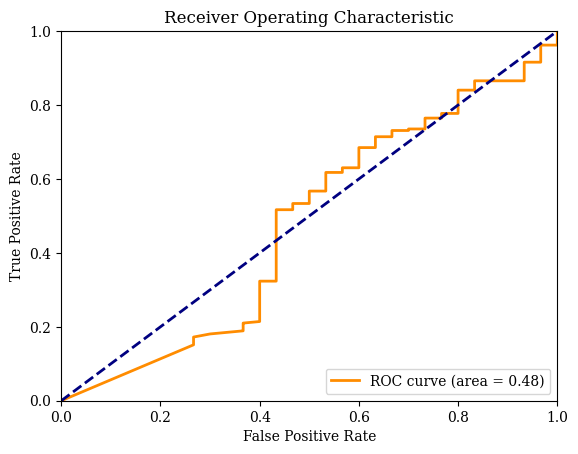

/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_222' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 356787.77it/s]
/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_216' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 348113.49it/s]


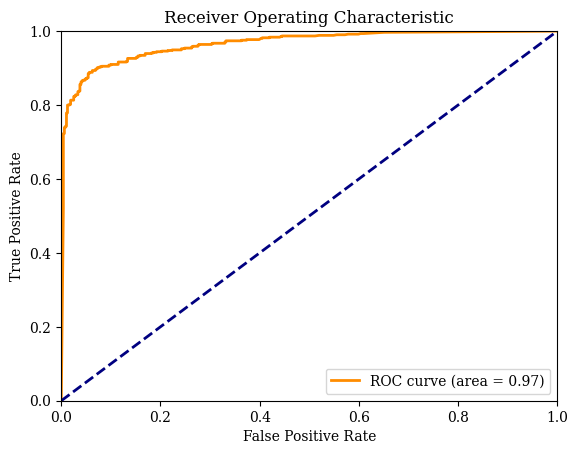

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 169211.72it/s]


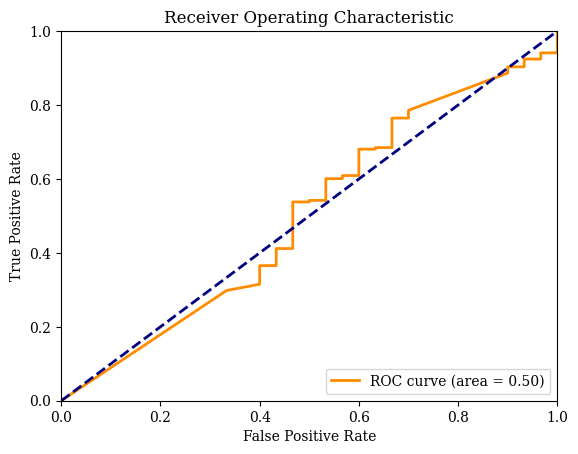

8/8 iterations


/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_225' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 364561.98it/s]


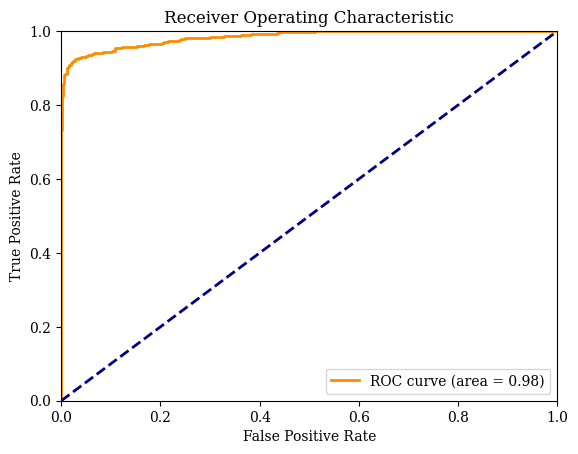

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 343648.26it/s]


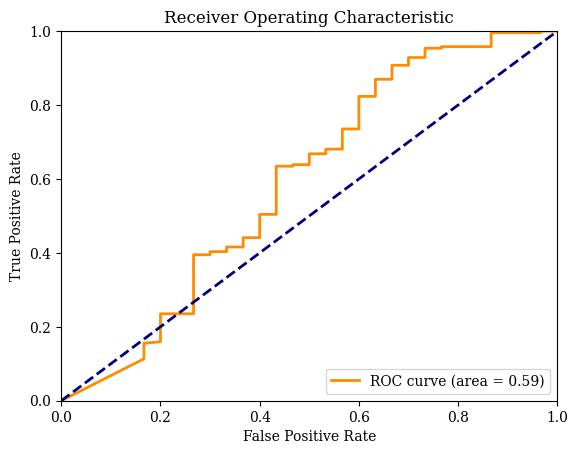

/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_231' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 375470.37it/s]
/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_225' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


100%|███████████████████████████████████| 1089/1089 [00:00<00:00, 374823.33it/s]


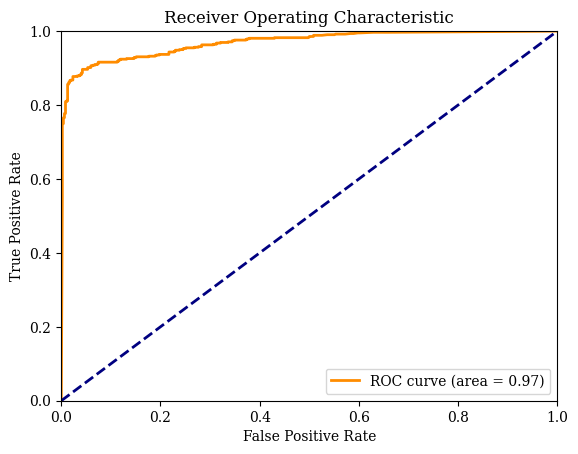

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|█████████████████████████████████████| 268/268 [00:00<00:00, 352705.83it/s]


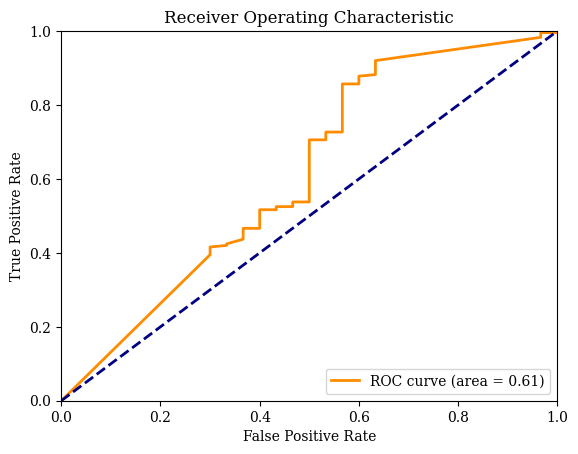

In [50]:
kf = KFold(n_splits=8, shuffle=True)

class_list = {'0': 'A' , '1': 'B'}

all_cor = []
all_a_mis = []
all_b_mis = []
all2_cor = []
all2_a_mis = []
all2_b_mis = []
all_both_cor = []
all_both_a_mis = []
all_both_b_mis = []
val_cor = []
val_a_mis = []
val_b_mis = []
val2_cor = []
val2_a_mis = []
val2_b_mis = []
val_both_cor = []
val_both_a_mis = []
val_both_b_mis = []

preds1_list = []
preds2_list = []
preds4_list = []
preds_com_list = []
preds_real_list = []

fpr_syn = []
tpr_syn = []
fpr_real = []
tpr_real = []
fpr2_syn = []
tpr2_syn = []
fpr2_real = []
tpr2_real = []

i_c = 0
for train_ind, val_ind in kf.split(data):
    print(f"{i_c+1}/8 iterations")
    i_c += 1
    
    data_train, data_val = data[train_ind], data[val_ind]
    data_deriv_train, data_deriv_val = data_deriv[train_ind], data_deriv[val_ind]
    labels_train, labels_val = np.array(labels)[train_ind], np.array(labels)[val_ind]
    ids_train, ids_val = np.array(ids)[train_ind], np.array(ids)[val_ind]

    ################################## MODEL 1
    
    model1 = generate_new_model(data_shape=(data_train.shape[1], 1))
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model1.fit(np.array(data_train), np.array(labels_train), epochs=100, batch_size=32, validation_split=0.2, verbose=0, callbacks=[reduce_lr, early_stopping])

    ################################## MODEL 1 SNYTH DATA

    preds1 = model1.predict(np.expand_dims(data_val, axis=-1))

    preds1_list.append(preds1.flatten())

    a_mis = 0
    b_mis = 0
    correct = 0
    
    for i, pred in enumerate(tqdm(preds1)):
        pred_class = int(np.round(pred[0]))
    
        if class_list[str(pred_class)] != class_list[str(labels_val[i])]:
            if labels_val[i] == 0:
                a_mis += 1
            else:
                b_mis += 1
        else:
            correct += 1

    all_cor.append(correct/len(preds1))
    all_a_mis.append(1 - a_mis/len(labels_val[labels_val==0]))
    all_b_mis.append(1 - b_mis/len(labels_val[labels_val==1]))

    fpr, tpr = plot_roc(labels_val, preds1.flatten())

    fpr_syn.append(fpr)
    tpr_syn.append(tpr)

    ################################## MODEL 1 REAL DATA

    preds4 = model1.predict(np.expand_dims(real_data, axis=-1))

    preds4_list.append(preds4.flatten())

    a_mis = 0
    b_mis = 0
    correct = 0
    
    for i, pred in enumerate(tqdm(preds4)):
        pred_class = int(np.round(pred[0]))
    
        if class_list[str(pred_class)] != class_list[str(real_labels[i])]:
            if real_labels[i] == 0:
                a_mis += 1
            else:
                b_mis += 1
        else:
            correct += 1

    val_cor.append(correct/len(preds4))
    val_a_mis.append(1 - a_mis/len(real_labels[real_labels==0]))
    val_b_mis.append(1 - b_mis/len(real_labels[real_labels==1]))

    fpr, tpr = plot_roc(real_labels, preds4.flatten())

    fpr_real.append(fpr)
    tpr_real.append(tpr)

    ################################## MODEL 2 SYNTH DATA

    model2 = generate_new_deriv_model(data_shape=(data_deriv_train.shape[1], 1))
    
    reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    early_stopping2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model2.fit(np.array(data_deriv_train), np.array(labels_train), epochs=100, batch_size=32, validation_split=0.2, verbose=0, callbacks=[reduce_lr2, early_stopping2])

    preds2 = model2.predict(np.expand_dims(data_deriv_val, axis=-1))

    preds2_list.append(preds2.flatten())

    a_mis = 0
    b_mis = 0
    correct = 0
    
    for i, pred in enumerate(tqdm(preds2)):
        pred_class = int(np.round(pred[0]))
    
        if class_list[str(pred_class)] != class_list[str(labels_val[i])]:
            if labels_val[i] == 0:
                a_mis += 1
            else:
                b_mis += 1
        else:
            correct += 1

    all2_cor.append(correct/len(preds2))
    all2_a_mis.append(1 - a_mis/len(labels_val[labels_val==0]))
    all2_b_mis.append(1 - b_mis/len(labels_val[labels_val==1]))

    ################################## MERGE MODELS

    input_shape_1 = (len(data_train[0]), 1)
    input_shape_2 = (len(data_deriv_train[0]), 1)
    
    input1 = Input(shape=input_shape_1)
    input2 = Input(shape=input_shape_2)
    
    output1 = model1(input1)
    output2 = model2(input2)
    
    merged = Concatenate()([model1.output, model2.output])
    
    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.5)(x)
    
    final_output = Dense(1, activation='sigmoid')(x)

    reduce_lr_com = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    early_stopping_com = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    combined_model = Model(inputs=[model1.input, model2.input], outputs=final_output)
    combined_model.compile(optimizer=Adam(learning_rate=initial_lr), loss='binary_crossentropy', metrics=['accuracy'])

    combined_model.fit([data_train, data_deriv_train], np.array(labels_train), epochs=100, batch_size=32, validation_split=0.2, verbose=0, callbacks=[reduce_lr_com, early_stopping_com])

    ################################## MERGED MODEL SYNTH DATA

    preds_com = combined_model.predict([np.expand_dims(data_val, axis=-1), np.expand_dims(data_deriv_val, axis=-1)])

    preds_com_list.append(preds_com.flatten())

    a_mis = 0
    b_mis = 0
    correct = 0
    
    for i, pred in enumerate(tqdm(preds_com)):
        pred_class = int(np.round(pred[0]))
    
        if class_list[str(pred_class)] != class_list[str(labels_val[i])]:
            if labels_val[i] == 0:
                a_mis += 1
            else:
                b_mis += 1
        else:
            correct += 1

    all_both_cor.append(correct/len(preds_com))
    all_both_a_mis.append(1 - a_mis/len(labels_val[labels_val==0]))
    all_both_b_mis.append(1 - b_mis/len(labels_val[labels_val==1]))

    fpr, tpr = plot_roc(labels_val, preds_com.flatten())

    fpr2_syn.append(fpr)
    tpr2_syn.append(tpr)

    ################################## MERGED MODEL REAL DATA

    preds_real = combined_model.predict([np.expand_dims(real_data, axis=-1), np.expand_dims(real_data_deriv, axis=-1)])

    preds_real_list.append(preds_real.flatten())

    a_mis = 0
    b_mis = 0
    correct = 0
    
    for i, pred in enumerate(tqdm(preds_real)):
        pred_class = int(np.round(pred[0]))
    
        if class_list[str(pred_class)] != class_list[str(real_labels[i])]:
            if real_labels[i] == 0:
                a_mis += 1
            else:
                b_mis += 1
        else:
            correct += 1

    val_both_cor.append(correct/len(preds_real))
    val_both_a_mis.append(1 - a_mis/len(real_labels[real_labels==0]))
    val_both_b_mis.append(1 - b_mis/len(real_labels[real_labels==1]))

    fpr, tpr = plot_roc(real_labels, preds_real.flatten())

    fpr2_real.append(fpr)
    tpr2_real.append(tpr)

    del model1
    del model2
    del combined_model

In [49]:
model1.save('model1.keras')
np.savetxt('val_ind.txt', val_ind)

In [52]:
print(f"Model1 Overall Accuracy on Synth Data = {np.round(np.mean(all_cor)*100, 1)} +/- {np.round(np.std(all_cor)*100/np.sqrt(8), 1)}%")
print(f"Model1 Type A Accuracy on Synth Data = {np.round(np.mean(all_a_mis)*100, 1)} +/- {np.round(np.std(all_a_mis)*100/np.sqrt(8), 1)}%")
print(f"Model1 Type B Accuracy on Synth Data = {np.round(np.mean(all_b_mis)*100, 1)} +/- {np.round(np.std(all_b_mis)*100/np.sqrt(8), 1)}%")

print(f"Model2 Overall Accuracy on Synth Data = {np.round(np.mean(all2_cor)*100, 1)}%")
print(f"Model2 Type A Accuracy on Synth Data = {np.round(np.mean(all2_a_mis)*100, 1)}%")
print(f"Model2 Type B Accuracy on Synth Data = {np.round(np.mean(all2_b_mis)*100, 1)}%")

print(f"Model1 Overall Accuracy on Real Data = {np.round(np.mean(val_cor)*100, 1)} +/- {np.round(np.std(val_cor)*100/np.sqrt(8), 1)}%")
print(f"Model1 Type A Accuracy on Real Data = {np.round(np.mean(val_a_mis)*100, 1)} +/- {np.round(np.std(val_a_mis)*100/np.sqrt(8), 1)}%")
print(f"Model1 Type B Accuracy on Real Data = {np.round(np.mean(val_b_mis)*100, 1)} +/- {np.round(np.std(val_b_mis)*100/np.sqrt(8), 1)}%")

print(f"Combined Model Overall Accuracy on Synth Data = {np.round(np.mean(all_both_cor)*100, 1)} +/- {np.round(np.std(all_both_cor)*100/np.sqrt(8), 1)}%")
print(f"Combined Model Type A Accuracy on Synth Data = {np.round(np.mean(all_both_a_mis)*100, 1)} +/- {np.round(np.std(all_both_a_mis)*100/np.sqrt(8), 1)}%")
print(f"Combined Model Type B Accuracy on Synth Data = {np.round(np.mean(all_both_b_mis)*100, 1)} +/- {np.round(np.std(all_both_b_mis)*100/np.sqrt(8), 1)}%")

print(f"Combined Model Overall Accuracy on Real Data = {np.round(np.mean(val_both_cor)*100, 1)} +/- {np.round(np.std(val_both_cor)*100/np.sqrt(8), 1)}%")
print(f"Combined Model Type A Accuracy on Real Data = {np.round(np.mean(val_both_a_mis)*100, 1)} +/- {np.round(np.std(val_both_a_mis)*100/np.sqrt(8), 1)}%")
print(f"Combined Model Type B Accuracy on Real Data = {np.round(np.mean(val_both_b_mis)*100, 1)} +/- {np.round(np.std(val_both_b_mis)*100/np.sqrt(8), 1)}%")

Model1 Overall Accuracy on Synth Data = 94.2 +/- 0.4%
Model1 Type A Accuracy on Synth Data = 96.1 +/- 0.5%
Model1 Type B Accuracy on Synth Data = 92.7 +/- 0.6%
Model2 Overall Accuracy on Synth Data = 89.0%
Model2 Type A Accuracy on Synth Data = 85.8%
Model2 Type B Accuracy on Synth Data = 91.3%
Model1 Overall Accuracy on Real Data = 65.7 +/- 1.0%
Model1 Type A Accuracy on Real Data = 46.2 +/- 1.9%
Model1 Type B Accuracy on Real Data = 68.1 +/- 1.1%
Combined Model Overall Accuracy on Synth Data = 88.8 +/- 0.8%
Combined Model Type A Accuracy on Synth Data = 86.8 +/- 2.0%
Combined Model Type B Accuracy on Synth Data = 90.2 +/- 1.2%
Combined Model Overall Accuracy on Real Data = 83.1 +/- 2.5%
Combined Model Type A Accuracy on Real Data = 10.8 +/- 5.5%
Combined Model Type B Accuracy on Real Data = 92.2 +/- 3.5%


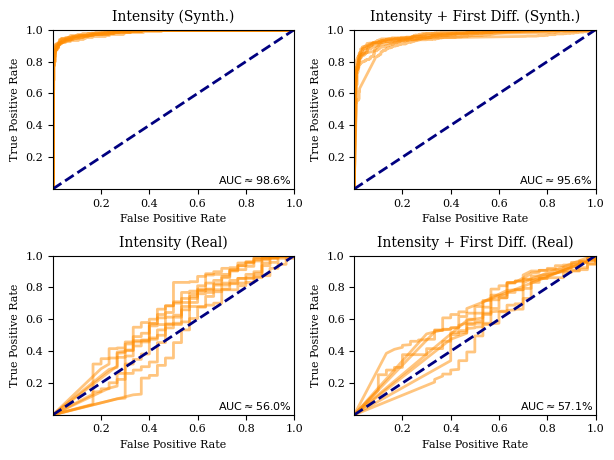

In [46]:
plt.rcParams['font.family'] = 'serif'

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 5))

auc_val = []

for i in range(len(fpr_syn)):
    auc_val.append(auc(fpr_syn[i], tpr_syn[i]))

    ax1.plot(fpr_syn[i], tpr_syn[i], color='darkorange', lw=2, alpha=0.5)
    
ax1.plot(np.logspace(-5,0,100), np.logspace(-5,0,100), color='navy', lw=2, linestyle='--')

ax1.text(0.99, 0.03, r"$\mathrm{AUC} \approx " + str(np.round(np.mean(auc_val)*100, 1)) + '\%$', ha='right', transform=ax1.transAxes, fontsize=8)

ax1.set_xlim([0.001, 1.0])
ax1.set_ylim([0.001, 1.0])

ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.set_xlabel('False Positive Rate', fontsize=8)
ax1.set_ylabel('True Positive Rate', fontsize=8)

ax1.set_title('Intensity (Synth.)', fontsize=10)

auc_val = []

for i in range(len(fpr2_syn)):
    auc_val.append(auc(fpr2_syn[i], tpr2_syn[i]))

    ax2.plot(fpr2_syn[i], tpr2_syn[i], color='darkorange', lw=2, alpha=0.5)
    
ax2.plot(np.logspace(-5,0,100), np.logspace(-5,0,100), color='navy', lw=2, linestyle='--')

ax2.text(0.99, 0.03, r"$\mathrm{AUC} \approx " + str(np.round(np.mean(auc_val)*100, 1)) + '\%$', ha='right', transform=ax2.transAxes, fontsize=8)

ax2.set_xlim([0.001, 1.0])
ax2.set_ylim([0.001, 1.0])

ax2.tick_params(axis='both', which='major', labelsize=8)

ax2.set_xlabel('False Positive Rate', fontsize=8)
ax2.set_ylabel('True Positive Rate', fontsize=8)

ax2.set_title('Intensity + First Diff. (Synth.)', fontsize=10)

auc_val = []

for i in range(len(fpr_real)):
    auc_val.append(auc(fpr_real[i], tpr_real[i]))

    ax3.plot(fpr_real[i], tpr_real[i], color='darkorange', lw=2, alpha=0.5)
    
ax3.plot(np.logspace(-5,0,100), np.logspace(-5,0,100), color='navy', lw=2, linestyle='--')

ax3.text(0.99, 0.03, r"$\mathrm{AUC} \approx " + str(np.round(np.mean(auc_val)*100, 1)) + '\%$', ha='right', transform=ax3.transAxes, fontsize=8)

ax3.set_xlim([0.001, 1.0])
ax3.set_ylim([0.001, 1.0])

ax3.tick_params(axis='both', which='major', labelsize=8)

ax3.set_xlabel('False Positive Rate', fontsize=8)
ax3.set_ylabel('True Positive Rate', fontsize=8)

ax3.set_title('Intensity (Real)', fontsize=10)

auc_val = []

for i in range(len(fpr2_real)):
    auc_val.append(auc(fpr2_real[i], tpr2_real[i]))

    ax4.plot(fpr2_real[i], tpr2_real[i], color='darkorange', lw=2, alpha=0.5)
    
ax4.plot(np.logspace(-5,0,100), np.logspace(-5,0,100), color='navy', lw=2, linestyle='--')

ax4.text(0.99, 0.03, r"$\mathrm{AUC} \approx " + str(np.round(np.mean(auc_val)*100, 1)) + '\%$', ha='right', transform=ax4.transAxes, fontsize=8)

ax4.set_xlim([0.001, 1.0])
ax4.set_ylim([0.001, 1.0])

ax4.tick_params(axis='both', which='major', labelsize=8)

ax4.set_xlabel('False Positive Rate', fontsize=8)
ax4.set_ylabel('True Positive Rate', fontsize=8)

ax4.set_title('Intensity + First Diff. (Real)', fontsize=10)

plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.42)

plt.savefig('AUC.pdf', bbox_inches='tight', pad_inches=0.01)

plt.show()